In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Reshape, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import imgaug.augmenters as iaa
import numpy as np

# Load bộ dữ liệu MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [3]:
X_train = X_train.reshape(-1, 28,  28)
X_test = X_test.reshape(-1, 28, 28)

In [4]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [6]:
seq = iaa.Sequential([
    iaa.Rotate((-20, 20)),  # xoay ảnh
    iaa.GaussianBlur(sigma=(0, 3.0)), # làm mờ
    iaa.AdditiveGaussianNoise(scale=0.05*255), # thêm nhiễu
    iaa.Flipud(), # lật ảnh theo chiều dọc
    iaa.Affine(translate_percent={"x": (-10, 10), "y": (-10, 10)}) # dịch chuyển ảnh ngẫu nhiên
])

In [7]:
# augmentation image
x = X_train.copy()

for i in range(3):
  print(f'<============= {i+1} =============>')
  images_aug = seq(images = x)
  X_train = np.concatenate((X_train, images_aug), axis=0)

# duplicates label  
y_train = np.tile(y_train, (4, 1)) # (11, 1) because y_train 2 dims

<============= 1 =============>
<============= 2 =============>
<============= 3 =============>


In [8]:
X_train = X_train.reshape(-1, 28 * 28)
X_test = X_test.reshape(-1, 28 * 28)

In [9]:
print(X_train.shape[0], y_train.shape[0])

240000 240000


In [10]:
train_concat = np.concatenate((X_train, y_train), axis=1)
test_concat = np.concatenate((X_test, y_test), axis=1)


train_sort_idx = np.argsort(train_concat[:, -1])
train_sort = train_concat[train_sort_idx]

test_sort_idx = np.argsort(test_concat[:, -1])
test_sort = test_concat[test_sort_idx]

In [11]:
# Tiền xử lý dữ liệu
X_train = train_sort[:, :-1]
X_train = X_train.reshape(X_train.shape[0], 28, 28)
y_train = train_sort[:, -1]

X_test = test_sort[:, :-1]
X_test = X_test.reshape(X_test.shape[0], 28, 28)
y_test = test_sort[:, -1]

In [12]:
# Chuyển đổi nhãn thành one-hot encoding
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [13]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Reshape((1, -1)))
model.add(LSTM(64, return_sequences=False))

model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 11, 11, 64)       2

In [14]:
import keras
import matplotlib.pyplot as plt
from IPython.display import clear_output
class PlotLosses (keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i+= 1

        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.legend()
        plt.show()
    
plot_losses = PlotLosses()

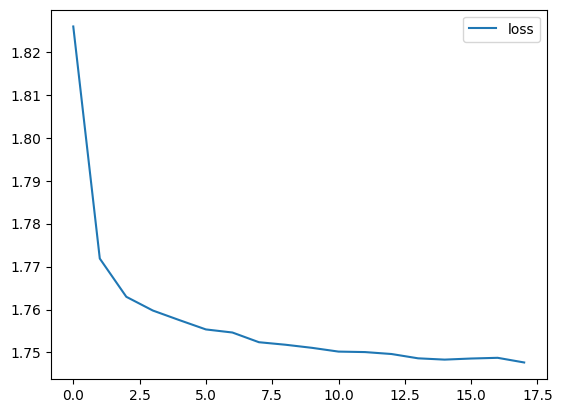

7500/7500 [==============================] - 54s 7ms/step - loss: 1.7477 - accuracy: 0.3282 - val_loss: 0.0501 - val_accuracy: 0.9889
Test loss: 0.05007760226726532
Test accuracy: 0.9889000058174133


In [15]:
# Compile và huấn luyện mô hình
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=0, validation_data=(X_test, y_test),  callbacks=[early_stop, plot_losses])
# val với tập train 

# Đánh giá mô hình trên tập dữ liệu kiểm tra
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import hamming_loss, jaccard_score, f1_score

y_true = y_test
y_true = np.argmax(y_true, axis = 1) # với mỗi ele lấy ra argmax (nhãn ban đầu) <=> 100000.. --> 1, 000...1 --> 9

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)

313/313 [==============================] - 1s 2ms/step


In [17]:
hml = hamming_loss(y_true, y_pred)
print(hml)

0.0111


In [18]:
# CONFUSION MATRIX
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[ 976    1    1    0    0    0    1    1    0    0]
 [   0 1130    1    2    0    0    1    1    0    0]
 [   2    1 1012    3    0    0    1   13    0    0]
 [   0    0    1 1002    0    3    0    3    1    0]
 [   1    0    0    0  968    0    4    0    0    9]
 [   3    0    0    3    0  883    1    1    1    0]
 [   3    2    0    0    1    4  947    0    1    0]
 [   1    2    6    0    0    1    0 1014    2    2]
 [   0    0    1    1    3    1    0    0  964    4]
 [   2    0    0    0    5    2    0    3    4  993]]


In [19]:
# classification report
target_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
cr = classification_report(y_true, y_pred, target_names=target_names)
print(cr)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.98      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.98      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [20]:
%cd /content/drive/MyDrive

from tensorflow.keras.models import load_model, save_model

save_model(model, 'model.h5')

/content/drive/MyDrive
